## 쇼핑몰  상품 카테고리 분류

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install konlpy
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 19.4MB 151kB/s 
     |████████████████████████████████| 3.6MB 53.6MB/s 
     |████████████████████████████████| 92kB 10.8MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
     |████████████████████████████████| 380.8MB 47kB/s 
     |████████████████████████████████| 450kB 49.8MB/s 
     |████████████████████████████████| 3.8MB 52.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=4d17475aaef9347ebdd8ccc7f120c4380670b39b70a7ecffdf89f76e3616131d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0

In [0]:
# 필요한 패키지 로드
import numpy as np
import pandas as pd
import random
import pickle
import re
import matplotlib.pyplot as plt
from collections import Counter

from konlpy.tag import Okt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Layer, Permute, BatchNormalization, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

seed = 2020

In [0]:
# train_chunk중에 1개만 사용
with open('/content/gdrive/My Drive/이커머스/train_chunk01.txt','rb') as f:
    df = pickle.load(f)
df = pd.DataFrame(df)
columns = ['pid','product','brand','model','maker','price',
           'bcateid','mcateid','scateid','dcateid']
df = df[columns]
df[['price','bcateid','mcateid','scateid','dcateid']] = df[['price','bcateid','mcateid','scateid','dcateid']].astype('int32')
df[['price','bcateid','mcateid','scateid','dcateid']] = df[['price','bcateid','mcateid','scateid','dcateid']].astype('int32')

### 전처리

In [5]:
# 한글 아닌 데이터 제거
df_pre = df.copy()
df_pre['product'] = df_pre['product'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
df_pre.head()

,pid,product,brand,model,maker,price,bcateid,mcateid,scateid,dcateid
0,b'O4486751463',직소퍼즐 조각 바다거북의 여행,퍼즐라이프,퍼즐라이프 직소퍼즐 바다거북의 여행,상품상세설명 참조,16520,1,1,2,-1
1,b'P3307178849',모리케이스 아이폰 다이어리케이스 바보사랑 ...,바보사랑,아이폰6S/6S+ tree farm101 - 다이어리케이스|아이폰6S/6S+,MORY|해당없음,20370,3,3,4,-1
2,b'R4424255515',크리비아 기모 부 속바지,크리비아,크리비아 기모 3부 속바지 GLG4314P,,-1,5,5,6,-1
3,b'F3334315393',하프클럽 잭앤질 남성 솔리드 절개라인 포인트 포켓 팬츠,잭앤질,[잭앤질] 남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,㈜크리스패션,16280,7,7,8,-1
4,b'N731678492',코드프리혈당시험지 매 코드프리시험지 최장유효기간,,SD코드프리혈당시험지[50매],기타,-1,10,9,11,-1


In [6]:
# 데이터중 상품명만 사용
corpus = df_pre['product'].tolist()
print(f'corpus size : {len(corpus)}')

corpus size : 1000000


In [0]:
# okt 형태소 분석기
okt = Okt()

In [8]:
# 상품명을 형태소 분석
tokenized_morphs = [okt.morphs(sentence, stem=True) for sentence in corpus]
len(tokenized_morphs)

1000000

In [10]:
# 단어의 개수
counter = Counter()
for i in tokenized_morphs:
    counter.update(Counter(i))
print("사용된 단어의 개수 %d" %len(counter))

사용된 단어의 개수 59500


In [0]:
# 35000개 단어만 사용
max_words = 35000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(tokenized_morphs)

In [0]:
# 중카테고리를 분류
train = tokenizer.texts_to_sequences(tokenized_morphs)
mcate = df['mcateid'].values

상품명의 최대 길이 : 51
상품명의 평균 길이 : 8.187812


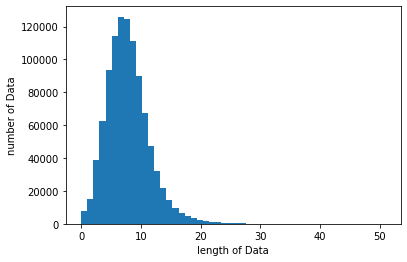

In [13]:
# 상품명의 길이 시각화
print('상품명의 최대 길이 :',max(len(l) for l in train))
print('상품명의 평균 길이 :',sum(map(len, train))/len(train))
plt.hist([len(s) for s in train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [0]:
# 길이가 25로 패딩
max_len=25
train = pad_sequences(train, maxlen=max_len)
y_len = len(df['mcateid'].unique())

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(train,mcate,test_size = 0.2,random_state = seed+1)

## transformer 기반 모델 구현

In [0]:
# 파라미터
d_model = 128
multi_heads = 4 # head의 개수
d_feedfoward = 256 # feedforward units

In [0]:
# positional encoding

def angle(pos, i):
    return pos / (np.power(10000, 2 * (i//2) / d_model))

def position_encoding(max_len, d_model):
    angles = angle(np.arange(max_len)[:,np.newaxis], 
                   np.arange(d_model)[np.newaxis,:])
    
    angles[:,0::2] = np.sin(angles[:,0::2])
    angles[:,1::2] = np.cos(angles[:,1::2])
    return angles

In [0]:
# query, key, value 생성

class MyGetWeight(Layer):

    def __init__(self, **kwargs):
        super(MyGetWeight, self).__init__()

    def build(self, input_shape):
        # query, key, value에 대한 가중치 행렬 생성
        self.W_q = self.add_weight(name = 'W_query', shape = (input_shape[-1], input_shape[-1]),
                                   initializer = 'random_normal', trainable = True)
        self.W_k = self.add_weight(name = 'W_key', shape = (input_shape[-1], input_shape[-1]),
                                   initializer = 'random_normal', trainable = True)
        self.W_v = self.add_weight(name = 'W_value', shape = (input_shape[-1], input_shape[-1]),
                                   initializer = 'random_normal', trainable = True)
    def call(self, inputs):
        query = tf.matmul(inputs, self.W_q)  # query
        key = tf.matmul(inputs, self.W_k)  # key
        value = tf.matmul(inputs, self.W_v)  # value
        # 각각 (None, 25, 128) 사이즈
        return query, key, value

In [0]:
# scaled_dot_product 연산 부분
# softmax 이용

def My_scaled_dot_product_attention(query, key, value):
    
    hidden = tf.matmul(query, key, transpose_b = True) # query와 key dot product
    dk = tf.cast(key.shape[-1], tf.float32) # 가중치 조정을 위한 scale값
    scaled_hidden = hidden / tf.math.sqrt(dk)

    attention_distribution = tf.nn.softmax(scaled_hidden, axis = -1) # 어텐션 분포
    attention_value = tf.matmul(attention_distribution, value) # 어텐션 값

    return attention_value, attention_distribution

In [0]:
# multi_head_attention 구현
# 여기서 head의 개수는 4개

class MyMultiHeadAttention(Layer):

    def __init__(self, d_model, max_len, multi_heads, **kwargs):
        super(MyMultiHeadAttention, self).__init__()
        self.d_model = d_model  # model의 차원
        self.multi_heads = multi_heads  # head의 개수
        self.max_len = max_len  # 패딩한 길이
        self.head_dim = self.d_model // self.multi_heads  # head하나의 차원

    def build(self, input_shape):
        # 가중치 행렬 shape = (None, 128, 128)
        self.W_0 = self.add_weight(name = 'W_0', shape = (input_shape[-1], input_shape[-1]),
                                   initializer = 'random_normal', trainable = True)
        
    def multi_head(self, inputs, batch_size):
        # 4개의 head로 split
        split_heads = tf.reshape(inputs, shape = (batch_size, self.max_len, self.multi_heads, self.head_dim))
        split_heads = tf.transpose(split_heads, perm = [0, 2, 1, 3])
        return split_heads
    
    def call(self, query, key, value):
        batch_size = tf.shape(query)[0]

        # query, key, value들을 split 각각 (None, 4, 25, 32) 사이즈
        query = self.multi_head(query, batch_size)
        key = self.multi_head(key, batch_size)
        value = self.multi_head(value, batch_size)

        # 만들어 놓은 scaled_dot_product 함수이용
        attention_value, attention_distribution = My_scaled_dot_product_attention(query, key, value) # 어텐션 값 (None, 4, 25, 32), 어텐션 분포 (None, 4, 25, 25)
        
        # 어텐션 값을 concate
        attention_value = tf.transpose(attention_value, perm = [0,2,1,3])
        concat_attention = tf.reshape(attention_value , shape = (batch_size,self.max_len,self.d_model)) # shape = (None, 25, 128)

        multi_head_attention_value = tf.matmul(concat_attention, self.W_0) # 가중치 곱

        return multi_head_attention_value, attention_distribution

(25, 128)


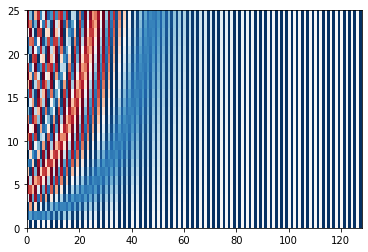

In [21]:
# positional encoding
angles = position_encoding(max_len, d_model)
print(angles.shape)
plt.pcolormesh(angles, cmap = 'RdBu')
plt.show()

In [27]:
inp = Input(shape = (max_len,))
embed = Embedding(max_words, d_model)(inp) # 단어 임베딩

angles = position_encoding(max_len, d_model)[np.newaxis,...]
positional_encoding = tf.cast(angles, dtype = tf.float32) # positional encoding
input_embedding = embed + positional_encoding

# query, key, value 생성
getweight = MyGetWeight()
query, key, value = getweight(input_embedding)

# 4개의 multihead attention 구현
multi_head_attention = MyMultiHeadAttention(d_model, max_len, multi_heads)
multi_head_attention_value, multi_head_attention_distribution = multi_head_attention(query, key, value)

# residual connection과 정규화
residual_layer1 = Add()([multi_head_attention_value, input_embedding])
residual_normalizer1 = BatchNormalization()(residual_layer1)

# position-wise feedforward net
feedforward_layer = Dense(d_feedfoward, activation = 'relu')(residual_normalizer1)  # relu 함수 이용
feedforward_layer = Dense(d_model)(feedforward_layer)

# residual connection과 정규화
residual_layer2 = Add()([residual_normalizer1, feedforward_layer])
residual_normalizer2 = BatchNormalization()(residual_layer2)

my_attention_value = tf.reduce_sum(residual_normalizer2, axis = 1)

output = Dense(y_len+1, activation = 'softmax')(my_attention_value)

model = Model(inputs = inp, outputs = output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 25, 128)      4480000     input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_add_4 (TensorFlowOp [(None, 25, 128)]    0           embedding_2[0][0]                
__________________________________________________________________________________________________
my_get_weight_2 (MyGetWeight)   ((None, 25, 128), (N 49152       tf_op_layer_add_4[0][0]          
____________________________________________________________________________________________

In [0]:
# 5번 학습
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam', metrics = ['acc'])
history = model.fit(X_train, Y_train, epochs=5, batch_size=60, validation_split=0.2)

Train on 640000 samples, validate on 160000 samples
Epoch 1/5
640000/640000 [==============================] - 732s 1ms/sample - loss: 0.8938 - acc: 0.8076 - val_loss: 0.5172 - val_acc: 0.8743
Epoch 2/5
640000/640000 [==============================] - 752s 1ms/sample - loss: 0.4262 - acc: 0.8899 - val_loss: 0.4436 - val_acc: 0.8894
Epoch 3/5
640000/640000 [==============================] - 753s 1ms/sample - loss: 0.3418 - acc: 0.9081 - val_loss: 0.3951 - val_acc: 0.8990
Epoch 4/5
640000/640000 [==============================] - 747s 1ms/sample - loss: 0.2865 - acc: 0.9209 - val_loss: 0.4046 - val_acc: 0.9024
Epoch 5/5
640000/640000 [==============================] - 735s 1ms/sample - loss: 0.2500 - acc: 0.9303 - val_loss: 0.3988 - val_acc: 0.9052


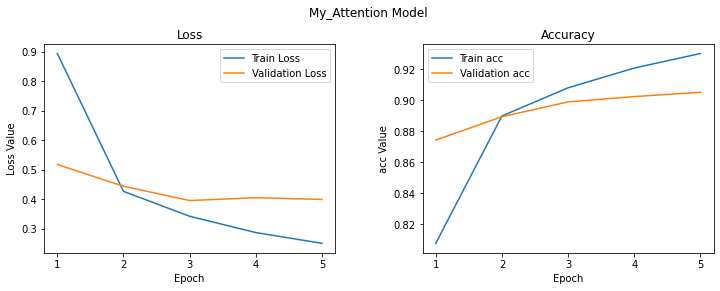

In [0]:
# loss, accuracy 시각화
epochs = len(history.history['loss'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('My_Attention Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['loss'], label='Train Loss')
ax1.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax1.set_xticks(np.arange(1, epochs+1))
ax1.set_ylabel('Loss Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Loss')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['acc'], label='Train acc')
ax2.plot(epoch_list, history.history['val_acc'], label='Validation acc')
ax2.set_xticks(np.arange(1, epochs+1))
ax2.set_ylabel('acc Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Accuracy')
l2 = ax2.legend(loc="best")

In [0]:
# validation data로 정확도 체크
print('테스트 정확도 : %lf' %(model.evaluate(X_val,Y_val)[1]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



테스트 정확도 : 0.905505
